In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 64

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([GlobalMaxPool1D()(output) for output in layer_outputs[-3:]])
    x = BatchNormalization()(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 64)    384         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 16000, 64)    256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16000, 64)    0           batch_normalization_v1[0][0]     
_____________________________________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 64)    384         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_9 (Batch (None, 16000, 64)    256         conv1d_7[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 64)    0           batch_normalization_v1_9[0][0]   
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 64)    384         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_22 (Batc (None, 16000, 64)    256         conv1d_18[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 64)    0           batch_normalization_v1_22[0][0]  
__________________________________________________________________________________________________
max_poolin

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0607 - acc: 0.3368
Epoch 00001: val_loss improved from inf to 2.07677, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_BN_3_conv_checkpoint/001-2.0768.hdf5
36805/36805 [==============================] - 56s 2ms/sample - loss: 2.0607 - acc: 0.3368 - val_loss: 2.0768 - val_acc: 0.3545
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5371 - acc: 0.5077
Epoch 00002: val_loss improved from 2.07677 to 1.42827, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_BN_3_conv_checkpoint/002-1.4283.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 1.5372 - acc: 0.5077 - val_loss: 1.4283 - val_acc: 0.5493
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4571 - acc: 0.8615
Epoch 00023: val_loss did not improve from 0.53953
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.4572 - acc: 0.8615 - val_loss: 0.5919 - val_acc: 0.8192
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4494 - acc: 0.8637
Epoch 00024: val_loss did not improve from 0.53953
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.4496 - acc: 0.8637 - val_loss: 0.5438 - val_acc: 0.8323
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4411 - acc: 0.8655
Epoch 00025: val_loss did not improve from 0.53953
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.4412 - acc: 0.8654 - val_loss: 0.5407 - val_acc: 0.8344
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4337 - acc: 0.8677
Epoch 00026: val_loss improved from 0.53953 to 0.50580, saving model to mod

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2820 - acc: 0.9149
Epoch 00052: val_loss did not improve from 0.47535
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.2820 - acc: 0.9148 - val_loss: 0.4931 - val_acc: 0.8563
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2809 - acc: 0.9134
Epoch 00053: val_loss did not improve from 0.47535
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.2810 - acc: 0.9134 - val_loss: 0.5173 - val_acc: 0.8463
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2783 - acc: 0.9140
Epoch 00054: val_loss did not improve from 0.47535
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.2784 - acc: 0.9140 - val_loss: 0.6514 - val_acc: 0.8081
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2710 - acc: 0.9181
Epoch 00055: val_loss did not improve from 0.47535
36805/36805 [===========

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1978 - acc: 0.9390
Epoch 00082: val_loss did not improve from 0.47535
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.1978 - acc: 0.9390 - val_loss: 0.6524 - val_acc: 0.8197
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1942 - acc: 0.9414
Epoch 00083: val_loss did not improve from 0.47535
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.1945 - acc: 0.9413 - val_loss: 0.6773 - val_acc: 0.8118
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1945 - acc: 0.9413
Epoch 00084: val_loss did not improve from 0.47535
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.1945 - acc: 0.9413 - val_loss: 0.5584 - val_acc: 0.8451
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1890 - acc: 0.9429
Epoch 00085: val_loss did not improve from 0.47535
36805/36805 [===========

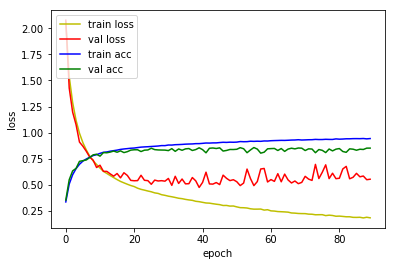

4815/4815 [==============================] - 3s 577us/sample - loss: 0.5715 - acc: 0.8216
Loss: 0.5714522497676243 Accuracy: 0.8215992

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9158 - acc: 0.3882
Epoch 00001: val_loss improved from inf to 1.81063, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_BN_4_conv_checkpoint/001-1.8106.hdf5
36805/36805 [==============================] - 57s 2ms/sample - loss: 1.9158 - acc: 0.3882 - val_loss: 1.8106 - val_acc: 0.4570
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2704 - acc: 0.6013
Epoch 00002: val_loss improved from 1.81063 to 1.10176, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_BN_4_conv_checkpoint/002-1.1018.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 1.2703 - acc: 0.6013 - val_loss: 1.1018 - val_acc: 0.6629
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s 

36800/36805 [============================>.] - ETA: 0s - loss: 0.2347 - acc: 0.9342
Epoch 00024: val_loss did not improve from 0.36984
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.2347 - acc: 0.9342 - val_loss: 0.3853 - val_acc: 0.8810
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2266 - acc: 0.9363
Epoch 00025: val_loss did not improve from 0.36984
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.2265 - acc: 0.9363 - val_loss: 0.3871 - val_acc: 0.8772
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2184 - acc: 0.9387
Epoch 00026: val_loss improved from 0.36984 to 0.36230, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_BN_4_conv_checkpoint/026-0.3623.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.2185 - acc: 0.9386 - val_loss: 0.3623 - val_acc: 0.8903
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2096 -

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0810 - acc: 0.9807
Epoch 00053: val_loss did not improve from 0.35575
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.0812 - acc: 0.9806 - val_loss: 0.3951 - val_acc: 0.8877
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0870 - acc: 0.9789
Epoch 00054: val_loss did not improve from 0.35575
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.0869 - acc: 0.9789 - val_loss: 0.3926 - val_acc: 0.8924
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0762 - acc: 0.9824
Epoch 00055: val_loss did not improve from 0.35575
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.0763 - acc: 0.9824 - val_loss: 0.3941 - val_acc: 0.8847
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0795 - acc: 0.9802
Epoch 00056: val_loss did not improve from 0.35575
36805/36805 [===========

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0323 - acc: 0.9944
Epoch 00083: val_loss did not improve from 0.35575
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.0325 - acc: 0.9943 - val_loss: 0.4825 - val_acc: 0.8775
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0446 - acc: 0.9891
Epoch 00084: val_loss did not improve from 0.35575
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.0448 - acc: 0.9891 - val_loss: 0.4508 - val_acc: 0.8854

1D_CNN_custom_multi_3_GMP_BN_4_conv Model


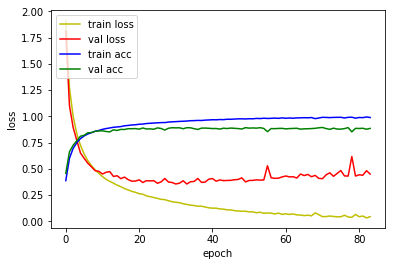

4815/4815 [==============================] - 3s 603us/sample - loss: 0.4344 - acc: 0.8708
Loss: 0.4343552954843111 Accuracy: 0.87082034

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6934 - acc: 0.4755
Epoch 00001: val_loss improved from inf to 1.44812, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_BN_5_conv_checkpoint/001-1.4481.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 1.6934 - acc: 0.4755 - val_loss: 1.4481 - val_acc: 0.5684
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8827 - acc: 0.7431
Epoch 00002: val_loss improved from 1.44812 to 0.69073, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_BN_5_conv_checkpoint/002-0.6907.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.8827 - acc: 0.7431 - val_loss: 0.6907 - val_acc: 0.7994
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s

36800/36805 [============================>.] - ETA: 0s - loss: 0.0702 - acc: 0.9858
Epoch 00025: val_loss did not improve from 0.24438
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0702 - acc: 0.9858 - val_loss: 0.2507 - val_acc: 0.9241
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0640 - acc: 0.9868
Epoch 00026: val_loss improved from 0.24438 to 0.23973, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_BN_5_conv_checkpoint/026-0.2397.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0641 - acc: 0.9868 - val_loss: 0.2397 - val_acc: 0.9287
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0635 - acc: 0.9864
Epoch 00027: val_loss did not improve from 0.23973
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0635 - acc: 0.9864 - val_loss: 0.2752 - val_acc: 0.9178
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0554 -

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0109 - acc: 0.9989
Epoch 00055: val_loss did not improve from 0.23973
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0110 - acc: 0.9988 - val_loss: 0.3428 - val_acc: 0.9126
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0368 - acc: 0.9902
Epoch 00056: val_loss did not improve from 0.23973
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0368 - acc: 0.9902 - val_loss: 0.2742 - val_acc: 0.9269
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0094 - acc: 0.9993
Epoch 00057: val_loss did not improve from 0.23973
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0095 - acc: 0.9993 - val_loss: 0.2791 - val_acc: 0.9313
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0086 - acc: 0.9991
Epoch 00058: val_loss did not improve from 0.23973
36805/36805 [===========

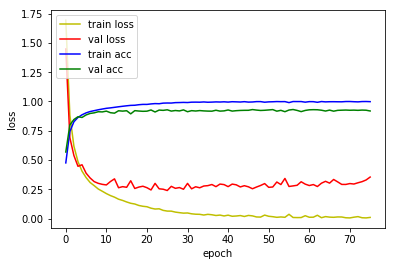

4815/4815 [==============================] - 3s 663us/sample - loss: 0.2917 - acc: 0.9146
Loss: 0.29169263855814315 Accuracy: 0.91464174

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2814 - acc: 0.6125
Epoch 00001: val_loss improved from inf to 0.98755, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_BN_6_conv_checkpoint/001-0.9876.hdf5
36805/36805 [==============================] - 65s 2ms/sample - loss: 1.2814 - acc: 0.6125 - val_loss: 0.9876 - val_acc: 0.7249
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5255 - acc: 0.8515
Epoch 00002: val_loss improved from 0.98755 to 0.40574, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_BN_6_conv_checkpoint/002-0.4057.hdf5
36805/36805 [==============================] - 55s 2ms/sample - loss: 0.5255 - acc: 0.8515 - val_loss: 0.4057 - val_acc: 0.8875
Epoch 3/500
36800/36805 [============================>.] - ETA: 0

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0173 - acc: 0.9976
Epoch 00027: val_loss did not improve from 0.16587
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0174 - acc: 0.9976 - val_loss: 0.2011 - val_acc: 0.9469
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0281 - acc: 0.9943
Epoch 00028: val_loss improved from 0.16587 to 0.16549, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_BN_6_conv_checkpoint/028-0.1655.hdf5
36805/36805 [==============================] - 55s 2ms/sample - loss: 0.0282 - acc: 0.9943 - val_loss: 0.1655 - val_acc: 0.9555
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0210 - acc: 0.9963
Epoch 00029: val_loss did not improve from 0.16549
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0210 - acc: 0.9963 - val_loss: 0.1803 - val_acc: 0.9495
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - l

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0050 - acc: 0.9995
Epoch 00056: val_loss did not improve from 0.16386
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0050 - acc: 0.9995 - val_loss: 0.1749 - val_acc: 0.9553
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0055 - acc: 0.9992
Epoch 00057: val_loss did not improve from 0.16386
36805/36805 [==============================] - 55s 2ms/sample - loss: 0.0055 - acc: 0.9992 - val_loss: 0.1922 - val_acc: 0.9497
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0094 - acc: 0.9981
Epoch 00058: val_loss did not improve from 0.16386
36805/36805 [==============================] - 55s 2ms/sample - loss: 0.0094 - acc: 0.9981 - val_loss: 0.2138 - val_acc: 0.9469
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0044 - acc: 0.9996
Epoch 00059: val_loss did not improve from 0.16386
36805/36805 [===========

Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0033 - acc: 0.9995
Epoch 00086: val_loss did not improve from 0.16386
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0033 - acc: 0.9995 - val_loss: 0.1971 - val_acc: 0.9550
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0017 - acc: 0.9999
Epoch 00087: val_loss did not improve from 0.16386
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0017 - acc: 0.9999 - val_loss: 0.2212 - val_acc: 0.9539
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0145 - acc: 0.9957
Epoch 00088: val_loss did not improve from 0.16386
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0145 - acc: 0.9957 - val_loss: 0.2129 - val_acc: 0.9525
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0088 - acc: 0.9979
Epoch 00089: val_loss did not improve from 0.16386
36805/36805 [===========

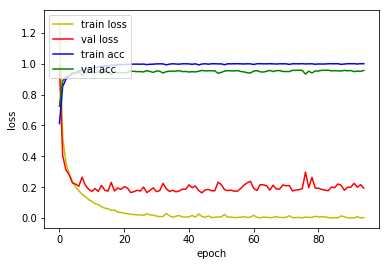

4815/4815 [==============================] - 3s 709us/sample - loss: 0.1957 - acc: 0.9464
Loss: 0.19572171869833768 Accuracy: 0.94641745

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0665 - acc: 0.6764
Epoch 00001: val_loss improved from inf to 0.76089, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_BN_7_conv_checkpoint/001-0.7609.hdf5
36805/36805 [==============================] - 70s 2ms/sample - loss: 1.0664 - acc: 0.6764 - val_loss: 0.7609 - val_acc: 0.7885
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4024 - acc: 0.8852
Epoch 00002: val_loss improved from 0.76089 to 0.28294, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_BN_7_conv_checkpoint/002-0.2829.hdf5
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.4024 - acc: 0.8852 - val_loss: 0.2829 - val_acc: 0.9252
Epoch 3/500
36800/36805 [============================>.] - ETA: 0

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0087 - acc: 0.9991
Epoch 00027: val_loss did not improve from 0.13241
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0087 - acc: 0.9990 - val_loss: 0.1361 - val_acc: 0.9620
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0203 - acc: 0.9958
Epoch 00028: val_loss did not improve from 0.13241
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0203 - acc: 0.9958 - val_loss: 0.1495 - val_acc: 0.9585
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0082 - acc: 0.9992
Epoch 00029: val_loss did not improve from 0.13241
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0082 - acc: 0.9992 - val_loss: 0.1497 - val_acc: 0.9592
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0145 - acc: 0.9975
Epoch 00030: val_loss did not improve from 0.13241
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0030 - acc: 0.9997
Epoch 00056: val_loss improved from 0.13011 to 0.12031, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_BN_7_conv_checkpoint/056-0.1203.hdf5
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0030 - acc: 0.9997 - val_loss: 0.1203 - val_acc: 0.9711
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0024 - acc: 0.9997
Epoch 00057: val_loss did not improve from 0.12031
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0024 - acc: 0.9997 - val_loss: 0.1444 - val_acc: 0.9646
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0020 - acc: 0.9999
Epoch 00058: val_loss did not improve from 0.12031
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0020 - acc: 0.9999 - val_loss: 0.1376 - val_acc: 0.9674
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0074 -

36800/36805 [============================>.] - ETA: 0s - loss: 0.0019 - acc: 0.9997
Epoch 00085: val_loss did not improve from 0.12031
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0019 - acc: 0.9997 - val_loss: 0.1336 - val_acc: 0.9693
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0016 - acc: 0.9998
Epoch 00086: val_loss did not improve from 0.12031
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0016 - acc: 0.9998 - val_loss: 0.1405 - val_acc: 0.9665
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0045 - acc: 0.9990
Epoch 00087: val_loss did not improve from 0.12031
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0045 - acc: 0.9990 - val_loss: 0.2062 - val_acc: 0.9492
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0043 - acc: 0.9992
Epoch 00088: val_loss did not improve from 0.12031
36805/36805 [========================

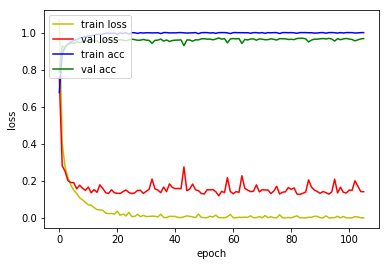

4815/4815 [==============================] - 4s 766us/sample - loss: 0.1808 - acc: 0.9529
Loss: 0.18081887631695467 Accuracy: 0.95285565

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9957 - acc: 0.6963
Epoch 00001: val_loss improved from inf to 0.85651, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_BN_8_conv_checkpoint/001-0.8565.hdf5
36805/36805 [==============================] - 76s 2ms/sample - loss: 0.9958 - acc: 0.6962 - val_loss: 0.8565 - val_acc: 0.7347
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3730 - acc: 0.8880
Epoch 00002: val_loss improved from 0.85651 to 0.26201, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_BN_8_conv_checkpoint/002-0.2620.hdf5
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.3730 - acc: 0.8880 - val_loss: 0.2620 - val_acc: 0.9255
Epoch 3/500
36800/36805 [============================>.] - ETA: 0

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0074 - acc: 0.9991
Epoch 00027: val_loss improved from 0.14531 to 0.14217, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_BN_8_conv_checkpoint/027-0.1422.hdf5
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0074 - acc: 0.9991 - val_loss: 0.1422 - val_acc: 0.9595
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0059 - acc: 0.9994
Epoch 00028: val_loss did not improve from 0.14217
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0059 - acc: 0.9994 - val_loss: 0.1442 - val_acc: 0.9592
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0086 - acc: 0.9984
Epoch 00029: val_loss did not improve from 0.14217
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0086 - acc: 0.9984 - val_loss: 0.1574 - val_acc: 0.9576
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - l

36800/36805 [============================>.] - ETA: 0s - loss: 0.0092 - acc: 0.9977
Epoch 00056: val_loss did not improve from 0.14217
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0094 - acc: 0.9977 - val_loss: 0.1526 - val_acc: 0.9634
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0090 - acc: 0.9980
Epoch 00057: val_loss did not improve from 0.14217
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0090 - acc: 0.9980 - val_loss: 0.1584 - val_acc: 0.9620
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0037 - acc: 0.9993
Epoch 00058: val_loss did not improve from 0.14217
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0037 - acc: 0.9993 - val_loss: 0.1666 - val_acc: 0.9634
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0017 - acc: 0.9998
Epoch 00059: val_loss did not improve from 0.14217
36805/36805 [========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0015 - acc: 0.9997
Epoch 00085: val_loss did not improve from 0.13454
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0015 - acc: 0.9997 - val_loss: 0.1533 - val_acc: 0.9632
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0080 - acc: 0.9975
Epoch 00086: val_loss did not improve from 0.13454
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0080 - acc: 0.9975 - val_loss: 0.1625 - val_acc: 0.9627
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0022 - acc: 0.9997
Epoch 00087: val_loss did not improve from 0.13454
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0022 - acc: 0.9997 - val_loss: 0.1769 - val_acc: 0.9609
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0053 - acc: 0.9987
Epoch 00088: val_loss did not improve from 0.13454
36805/36805 [========================

Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0011 - acc: 0.9999
Epoch 00115: val_loss did not improve from 0.13454
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0011 - acc: 0.9999 - val_loss: 0.1559 - val_acc: 0.9646
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0029 - acc: 0.9995
Epoch 00116: val_loss did not improve from 0.13454
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0029 - acc: 0.9995 - val_loss: 0.1551 - val_acc: 0.9634
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0074 - acc: 0.9979
Epoch 00117: val_loss did not improve from 0.13454
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0074 - acc: 0.9979 - val_loss: 0.1660 - val_acc: 0.9646
Epoch 118/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0065 - acc: 0.9979
Epoch 00118: val_loss did not improve from 0.13454
36805/36805 [=======

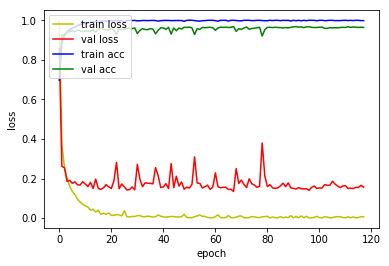

4815/4815 [==============================] - 4s 800us/sample - loss: 0.1825 - acc: 0.9566
Loss: 0.1825448181131286 Accuracy: 0.956594



In [10]:
base = '1D_CNN_custom_multi_3_GMP_BN'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_3_GMP_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_3_GMP_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 64)    384         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_39 (Batc (None, 16000, 64)    256         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 64)    0           batch_normalization_v1_39[0][0]  
__________________________________________________________________

4815/4815 [==============================] - 4s 804us/sample - loss: 0.4344 - acc: 0.8708
Loss: 0.4343552954843111 Accuracy: 0.87082034

1D_CNN_custom_multi_3_GMP_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 64)    384         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_48 (Batc (None, 16000, 64)    256         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activation)   

4815/4815 [==============================] - 4s 874us/sample - loss: 0.1957 - acc: 0.9464
Loss: 0.19572171869833768 Accuracy: 0.94641745

1D_CNN_custom_multi_3_GMP_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 64)    384         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_61 (Batc (None, 16000, 64)    256         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activation)  

4815/4815 [==============================] - 5s 959us/sample - loss: 0.1825 - acc: 0.9566
Loss: 0.1825448181131286 Accuracy: 0.956594


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_BN_2'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_3_GMP_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 64)    384         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_39 (Batc (None, 16000, 64)    256         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 64)    0           batch_normalization_v1_39[0][0]  
__________________________________________________________________

4815/4815 [==============================] - 5s 944us/sample - loss: 0.5381 - acc: 0.8685
Loss: 0.5381309267145079 Accuracy: 0.8685358

1D_CNN_custom_multi_3_GMP_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 64)    384         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_48 (Batc (None, 16000, 64)    256         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activation)    

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2201 - acc: 0.9468
Loss: 0.2201064288124891 Accuracy: 0.94683284

1D_CNN_custom_multi_3_GMP_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 64)    384         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_61 (Batc (None, 16000, 64)    256         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activation)     

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2142 - acc: 0.9526
Loss: 0.21417210460036049 Accuracy: 0.952648
